In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from trajectory import run_simulation_trajectory
%load_ext autoreload
%autoreload 2

In [2]:
n = 10000 # Starting plankton population size.
iters = 30 # Time steps.
L_max = 1 # Size of square domain.
colour_map = "hsv"

plankton_dict = run_simulation_trajectory(n, iters, L_max, False)

In [3]:
x = []
y = []
y0 = []
for id in plankton_dict:
    x.append(plankton_dict[id]['x'][-1])
    y.append(plankton_dict[id]['y'][-1])
    y0.append(plankton_dict[id]['y0'])

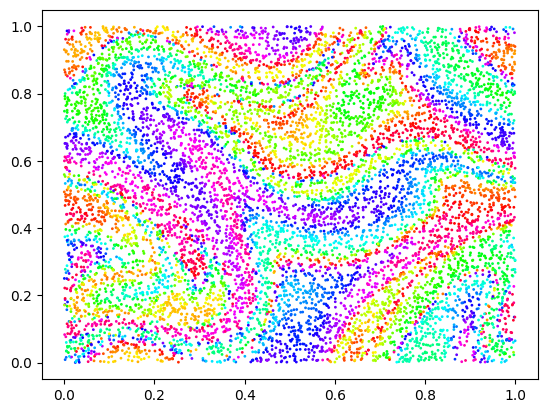

In [4]:
plt.scatter(x, y, c=y0, s=1, cmap=colour_map)
plt.show()

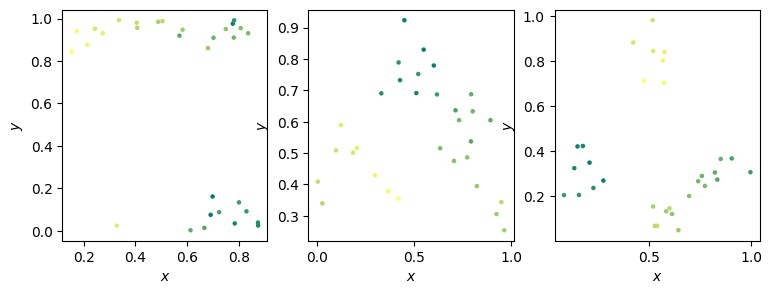

In [47]:
fig, ax = plt.subplots(1,3, figsize=(9,3))

for i,id in enumerate([0,50,100]):
    ax.flatten()[i].set_xlabel('$x$')
    ax.flatten()[i].set_ylabel('$y$')
    ax.flatten()[i].scatter(plankton_dict[id]['x'], plankton_dict[id]['y'], 
                            c=plankton_dict[id]['t'], cmap='summer', s=5)

In [5]:
n = 1000 # Starting plankton population size.
iters = 30 # Time steps.
L_max = 1 # Size of square domain.
colour_map = "hsv"

plankton_dict = run_simulation_trajectory(n, iters, L_max, True)

In [6]:
x = []
y = []
y0 = []
t_final = []
for id in plankton_dict:
    x.append(plankton_dict[id]['x'][-1])
    y.append(plankton_dict[id]['y'][-1])
    t_final.append(plankton_dict[id]['t'][-1])
    y0.append(plankton_dict[id]['y0'])

In [8]:
final_idx = np.where(t_final==np.max(t_final))[0]

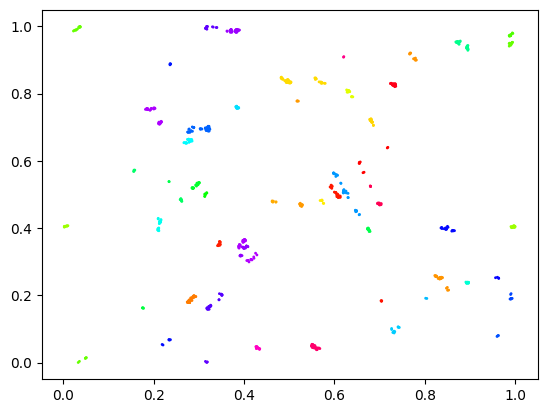

In [9]:
plt.scatter(np.array(x)[final_idx], np.array(y)[final_idx], c=np.array(y0)[final_idx], s=1, cmap=colour_map)
plt.show()

In [12]:
traj_len = []
for id in plankton_dict:
    traj_len.append(len(plankton_dict[id]['x']))
np.where(np.array(traj_len)>=10)

(array([ 1041,  1119,  1253,  1789,  2000,  2045,  2457,  2563,  3045,
         3395,  3640,  4003,  5510,  5562,  5993,  6418,  6830,  6848,
         7057,  7684,  8444,  8584,  8810,  9681, 11733, 11829]),)

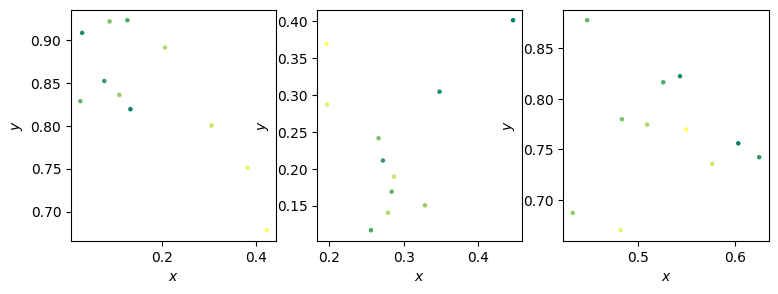

In [7]:
fig, ax = plt.subplots(1,3, figsize=(9,3))

for i,id in enumerate([378,4697,11385]):
    ax.flatten()[i].set_xlabel('$x$')
    ax.flatten()[i].set_ylabel('$y$')
    ax.flatten()[i].scatter(plankton_dict[id]['x'], plankton_dict[id]['y'], 
                            c=plankton_dict[id]['t'], cmap='summer', s=5)

## extract training data

In [13]:
n = 1000 # Starting plankton population size.
iters = 30 # Time steps.
L_max = 1 # Size of square domain.

plankton_dict = run_simulation_trajectory(n, iters, L_max, True)

In [19]:
min_len = 5
traj_len = []

plankton_ids = list(plankton_dict.keys())
for id in plankton_dict:
    traj_len.append(len(plankton_dict[id]['t']))

# plankton ids with min trajectory length
plankton_min = np.where(np.array(traj_len)>=min_len)[0]

In [20]:
def get_coord(id, t):
    x = np.array(plankton_dict[id]['x'])[np.array(plankton_dict[id]['t'])==t]
    y = np.array(plankton_dict[id]['y'])[np.array(plankton_dict[id]['t'])==t]
    return [x,y]

In [21]:
min_len = 5
training_data = []

for i,id1 in enumerate(plankton_min):
    for id2 in plankton_min[i+1:]:
        traj_intersec = set(plankton_dict[id1]['t']).intersection(set(plankton_dict[id2]['t']))
        if (len(traj_intersec) >= min_len):
            #print(id1,id2)
            #print(traj_times[id1], traj_times[id2], traj_intersec)
            traj_intersec = list(traj_intersec)[:min_len] #cutting longer intersections
            t1 = traj_intersec[0] 
            t2 = traj_intersec[-1]
            a1 = get_coord(id1, t1)
            a2 = get_coord(id1, t2)
            b1 = get_coord(id2, t1)
            b2 = get_coord(id2, t2)
            training_data.append((np.array((a1,b1,a2,b2)).squeeze()))

In [22]:
len(training_data)

31109

In [24]:
np.save('training_data.npy', training_data)